# 0.0. Intruducao

## 0.1. Biblíotecas

In [50]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt

from scipy    import stats          as ss
from imblearn import under_sampling as us
from imblearn import over_sampling as oversemp

import warnings

warnings.filterwarnings('ignore')

## 0.2. Loading dos Dados

In [7]:
df = pd.read_csv( 'train_users_2.csv', low_memory = True )
df_sessions = pd.read_csv( 'sessions.csv', low_memory= True )

## 0.3. Funcoes Auxiliares

In [8]:
# get_stats
def get_stats(x):
    # Tendencia Central - mean, median
    tc1 = pd.DataFrame( x.apply( np.mean ) ).T
    tc2 = pd.DataFrame( x.apply( np.median ) ).T

    # Tendencia de dispersao - std, min, max, range, skew, kurtosis
    td1 = pd.DataFrame( x.apply( np.std ) ).T
    td2 = pd.DataFrame( x.apply( min ) ).T
    td3 = pd.DataFrame( x.apply( max ) ).T
    td4 = pd.DataFrame( x.apply( lambda i: i.max() - i.min() ) ).T
    td5 = pd.DataFrame( x.apply( lambda i: i.skew() ) ).T
    td6 = pd.DataFrame( x.apply( lambda i: i.kurtosis() ) ).T

    # concat
    ct = pd.concat( [td2, td3, td4, tc1, tc2, td1, td5, td6] ).T.reset_index()
    ct.columns = ['atributos', 'min', 'max', 'range', 'media', 'mediana', 'std', 'skew', 'kurtosis']
    
    return ct

#cramer_v function
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k - 1) * (r - 1) / (n-1) )
    
    kcorr = k - ( k - 1 ) ** 2 / ( n - 1 )
    rcorr = r - ( r - 1 ) ** 2 / ( n - 1 )
    
    return np.sqrt( (chi2corr / n) / (min( kcorr-1, rcorr-1 ) ) )

# 1.0. Descricao dos Dados

In [9]:
df1 = df.copy()
df1_sessions = df_sessions

## 1.1. Dimensionalidade

In [10]:
print( 'Número de linhas: {}'.format( df1.shape[0] ) )
print( 'Número de colunas: {}'.format( df1.shape[1] ) )

Número de linhas: 213451
Número de colunas: 16


In [11]:
print( 'Número de linhas: {}'.format( df1_sessions.shape[0] ) )
print( 'Número de colunas: {}'.format( df1_sessions.shape[1] ) )

Número de linhas: 1056773
Número de colunas: 6


## 1.2. Data type

In [12]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [13]:
df1_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

In [14]:
aux = df1[df1['age'].isna()]
aux['country_destination'].value_counts( normalize=True )

NDF      0.768428
US       0.156529
other    0.028617
FR       0.014888
IT       0.009081
GB       0.006251
ES       0.006171
CA       0.003989
DE       0.002387
NL       0.001818
AU       0.001171
PT       0.000671
Name: country_destination, dtype: float64

## 1.2. Check Na

### 1.2.1. Check df1

In [15]:
#porcentagem dos dados faltantes por feature
df1.isna().sum() / len( df1 )

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [16]:
# remover missing values

#date_first_booking
date_first_booking_max = pd.to_datetime( df1['date_first_booking'] ).max().strftime( '%Y-%m-%d' )
df1['date_first_booking'] = df1['date_first_booking'].fillna( date_first_booking_max )

#age
avg_age = df1['age'].mean().astype( int )
df1['age'] = df1['age'].fillna( avg_age )

#first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

df1.shape

(207386, 16)

### 1.2.2. Check df1_sessions

In [17]:
#porcentagem dos dados faltantes por feature
df1_sessions.isna().sum() / len( df1_sessions )

user_id          0.003225
action           0.007399
action_type      0.106714
action_detail    0.106714
device_type      0.000000
secs_elapsed     0.012966
dtype: float64

In [18]:
# drop na

#user_id - 0.3%
df1_sessions = df1_sessions[~df1_sessions['user_id'].isna()]

#action - 0.7%
df1_sessions = df1_sessions[~df1_sessions['action'].isna()]

#action_type - 10.6%
df1_sessions = df1_sessions[~df1_sessions['action_type'].isna()]

#action_detail - 10.6%
df1_sessions = df1_sessions[~df1_sessions['action_detail'].isna()]

#secs_elepsed - 1.2%
df1_sessions = df1_sessions[~df1_sessions['secs_elapsed'].isna()]

## 1.3. Change Types

In [19]:
#date_account_created
df1['date_account_created'] = pd.to_datetime( df['date_account_created'] )

#timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime( df['timestamp_first_active'], format = "%Y%m%d%H%M%S" )

#date_first_booking
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )

#age
df1['age'] = df1['age'].astype( int )

## 1.4. Check Balancemento dos Dados

In [20]:
df1['country_destination'].value_counts( normalize=True )

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

## 1.5. Estatistica Descritiva

In [21]:
atributos_num = df1.select_dtypes( include = [int, 'float64'] )
atributos_cat = df1.select_dtypes( exclude = [int, 'float64', 'datetime64[ns]'] )
atributos_time = df1.select_dtypes( include = ['datetime64[ns]'] )

In [22]:
atributos_num_sessions = df1_sessions.select_dtypes( include = ['float64'] )
atributos_cat_sessions = df1_sessions.select_dtypes( exclude = ['float64'] )

### 1.5.1. Atributos Numericos

#### 1.5.1.1. Users

In [23]:
get_stats( atributos_num )

,atributos,min,max,range,media,mediana,std,skew,kurtosis
0,age,1.0,2014.0,2013.0,49.183142,49.0,118.421689,16.333820,267.655434
1,signup_flow,0.0,25.0,25.0,3.151490,0.0,7.543915,2.287158,3.567794


#### 1.5.1.2. Sessions

In [24]:
get_stats( atributos_num_sessions )

,atributos,min,max,range,media,mediana,std,skew,kurtosis
0,secs_elapsed,0.0,1799646.0,1799646.0,20072.882262,1373.0,89371.933206,11.100057,153.74554


### 1.5.2. Atributos Categoricos

#### 1.5.2.1. Users

In [25]:
atributos_cat.drop( 'id', axis = 1 ).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,207386,207386,207386,207386,207386,207386,207386,207386,207386,207386
unique,4,3,25,8,18,7,4,9,52,12
top,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,91783,148297,200415,134179,133935,109232,178334,89600,63845,120216


#### 1.5.2.2. Sessions

In [26]:
atributos_cat_sessions.drop( 'user_id', axis = 1 ).describe()

,action,action_type,action_detail,device_type
count,921283,921283,921283,921283
unique,297,9,147,14
top,show,view,view_search_results,Mac Desktop
freq,217606,354973,177324,302022


### 1.5.3. Correlacao entre as variáveis categoricas

In [27]:
# lista de atributos para a corralação de Cramer V
cat_atributos_list = atributos_cat_sessions.drop( 'user_id', axis = 1 ).columns.tolist()

corr_dict = {}

for i in range( len( cat_atributos_list ) ):
    corr_list = []
    for j in range( len( cat_atributos_list ) ):
        ref = cat_atributos_list[i]
        feat = cat_atributos_list[j]
        
        # correlacao
        corr = cramer_v( atributos_cat_sessions[ref], atributos_cat_sessions[feat])
        
        # append a list
        corr_list.append( corr )
    
    # append a lista de correção para cada atributo
    corr_dict[ref] = corr_list

In [28]:
pd.DataFrame( corr_dict )

,action,action_type,action_detail,device_type
0,1.000161,0.947853,0.796982,0.259732
1,0.947853,1.000004,0.978187,0.087454
2,0.796982,0.978187,1.000079,0.219681
3,0.259732,0.087454,0.219681,1.000007


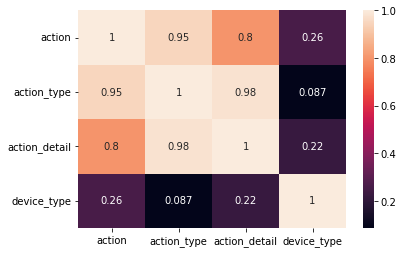

In [29]:
d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns )
sns.heatmap( d, annot = True );

# 2.0. Feature Engeneering

In [30]:
df2 = df1.copy()
df2_sessions = df1_sessions.copy()

In [31]:
df1.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,2015-06-29,-unknown-,49,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


## 2.1. Create new feature

In [32]:
# dias da ativação até o primeiro booking
df2['first_active'] = pd.to_datetime( df2['timestamp_first_active'].dt.strftime( '%Y-%m-%d' ) )
df2['days_from_first_active_until_booking'] = ( df2['date_first_booking'] - df2['first_active'] ).apply( lambda x: x.days )

# dias da primeira ativação até a creação da conta
df2['days_from_first_active_until_account_created'] = ( df2['date_account_created'] - df2['first_active'] ).apply( lambda x: x.days )

# dias da criação da conta até o primeiro booking
df2['days_from_account_created_until_booking'] = ( df2['date_first_booking'] - df2['date_account_created'] ).apply( lambda x: x.days )

# year first active
df2['year_first_active'] = df2['first_active'].dt.year
# month first active
df2['month_first_active'] = df2['first_active'].dt.month
# day first active
df2['day_first_active'] = df2['first_active'].dt.day
# day of week first active
df2['dayofweek_first_active'] = df2['first_active'].dt.dayofweek
# week of year first active
df2['weekofyear_first_active'] = df2['first_active'].dt.weekofyear

# year first booking
df2['year_first_booking'] = df2['first_active'].dt.year
# month first booking
df2['month_first_booking'] = df2['first_active'].dt.month
# day first booking
df2['day_first_booking'] = df2['first_active'].dt.day
# day of week first booking
df2['dayofweek_first_booking'] = df2['first_active'].dt.dayofweek
# week of year first booking
df2['weekofyear_first_booking'] = df2['first_active'].dt.weekofyear

# year first account_created
df2['year_first_account_created'] = df2['first_active'].dt.year
# month first account_created
df2['month_first_account_created'] = df2['first_active'].dt.month
# day first account_created
df2['day_first_account_created'] = df2['first_active'].dt.day
# day of week first account_createdg
df2['dayofweek_first_account_created'] = df2['first_active'].dt.dayofweek
# week of year first account_created
df2['weekofyear_first_account_created'] = df2['first_active'].dt.weekofyear

# 3.0. Data Filtering 

In [33]:
df3 = df2.copy()

## 3.1. Filtering rows

In [34]:
# maior do que 15 e menor do que 120 - existem poucas pessoas acima de 120 anos
df3 = df3[( df3['age'] > 15 ) & ( df3['age'] < 120 )]

## 3.2. Filtering cols

In [36]:
cols = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'first_active'] # datetime original
df3 = df3.drop( cols, axis = 1 )

# 4.0. Balancemento dos Dados

In [38]:
df4 = df3.copy()

## 4.1. Random Undersampling

In [45]:
# ratio_balanced
ratio_balanced = {'NDF': 20000, 'US': 12000}
# define sampler
undersampling = us.RandomUnderSampler( sampling_strategy= ratio_balanced, random_state = 32 )

# apply sampler
x_under, y_under = undersampling.fit_resample( df4, df4['country_destination'] )

In [46]:
df4['country_destination'].value_counts()

NDF      119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

In [47]:
y_under.value_counts()

NDF      20000
US       12000
other     9935
FR        4881
IT        2776
GB        2285
ES        2203
CA        1385
DE        1033
NL         746
AU         526
PT         213
Name: country_destination, dtype: int64

## 4.2. Random Oversampling

In [51]:
# ratio_balanced
# ratio_balanced = {'NDF': 20000, 'US': 12000}
# define sampler
oversampling = oversemp.RandomOverSampler( sampling_strategy= 'minority', random_state = 32 )

# apply sampler
x_over, y_over = oversampling.fit_resample( df4, df4['country_destination'] )

In [52]:
df4['country_destination'].value_counts()

NDF      119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

In [53]:
y_over.value_counts()

NDF      119810
PT       119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
Name: country_destination, dtype: int64

## 4.3. SMOTE + TOMEKLINK

# 5.0. Data preparation

In [31]:
df4 = df3.copy()

In [32]:
# dummy variable
df3_dummy = pd.get_dummies( df3.drop( ['id', 'country_destination'], axis = 1 ) )

# join id and country destination
df3 = pd.concat( [df3[['id', 'country_destination']], df3_dummy], axis = 1 )

In [33]:
df3.shape

(206593, 156)

# 6.0. Feature Selection

In [39]:
df4.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,year_first_booking,month_first_booking,day_first_booking,dayofweek_first_booking,weekofyear_first_booking,year_first_account_created,month_first_account_created,day_first_account_created,dayofweek_first_account_created,weekofyear_first_account_created
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,2015-06-29,-unknown-,49,facebook,0,en,direct,...,2009,3,19,3,12,2009,3,19,3,12
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,...,2009,5,23,5,21,2009,5,23,5,21
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,...,2009,6,9,1,24,2009,6,9,1,24
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,...,2009,10,31,5,44,2009,10,31,5,44
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,...,2009,12,8,1,50,2009,12,8,1,50
